# Credit Card Fraud

This dataset consists of credit card transactions in the western United States. It includes information about each transaction including customer details, the merchant and category of purchase, and whether or not the transaction was a fraud.

Not sure where to begin? Scroll to the bottom to find challenges!

In [2]:
import pandas as pd 
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import datetime as dt

In [3]:
#random state to random arbitrary 5000
rs = np.random.randint(5000)

ccf = pd.read_csv('credit_card_fraud.csv') 
ccf.head(5)

,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:44,"Heller, Gutmann and Zieme",grocery_pos,107.23,Orient,WA,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,49.159047,-118.186462,0
1,2019-01-01 00:00:51,Lind-Buckridge,entertainment,220.11,Malad City,ID,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,43.150704,-112.154481,0
2,2019-01-01 00:07:27,Kiehn Inc,grocery_pos,96.29,Grenada,CA,41.6125,-122.5258,589,Systems analyst,1945-12-21,413636e759663f264aae1819a4d4f231,41.657520,-122.230347,0
3,2019-01-01 00:09:03,Beier-Hyatt,shopping_pos,7.77,High Rolls Mountain Park,NM,32.9396,-105.8189,899,Naval architect,1967-08-30,8a6293af5ed278dea14448ded2685fea,32.863258,-106.520205,0
4,2019-01-01 00:21:32,Bruen-Yost,misc_pos,6.85,Freedom,WY,43.0172,-111.0292,471,"Education officer, museum",1967-08-02,f3c43d336e92a44fc2fb67058d5949e3,43.753735,-111.454923,0


## Data Dictionary

| transdatetrans_time | Transaction DateTime                        |
|---------------------|---------------------------------------------|
| merchant            | Merchant Name                               |
| category            | Category of Merchant                        |
| amt                 | Amount of Transaction                       |
| city                | City of Credit Card Holder                  |
| state               | State of Credit Card Holder                 |
| lat                 | Latitude Location of Purchase               |
| long                | Longitude Location of Purchase              |
| city_pop            | Credit Card Holder's City Population        |
| job                 | Job of Credit Card Holder                   |
| dob                 | Date of Birth of Credit Card Holder         |
| trans_num           | Transaction Number                          |
| merch_lat           | Latitude Location of Merchant               |
| merch_long          | Longitude Location of Merchant              |
| is_fraud            | Whether Transaction is Fraud (1) or Not (0) |

[Source](https://www.kaggle.com/kartik2112/fraud-detection?select=fraudTrain.csv) of dataset. The data was partially cleaned and adapted by DataCamp.

## Don't know where to start?

**Challenges are brief tasks designed to help you practice specific skills:**

- 🗺️ **Explore**: What types of purchases are most likely to be instances of fraud? Consider both product category and the amount of the transaction.
- 📊 **Visualize**: Use a geospatial plot to visualize the fraud rates across different states.
- 🔎 **Analyze**: Are older customers significantly more likely to be victims of credit card fraud?

**Scenarios are broader questions to help you develop an end-to-end project for your portfolio:**

A new credit card company has just entered the market in the western United States. The company is promoting itself as one of the safest credit cards to use. They have hired you as their data scientist in charge of identifying instances of fraud. The executive who hired you has have provided you with data on credit card transactions, including whether or not each transaction was fraudulent.

The executive wants to know how accurately you can predict fraud using this data. She has stressed that the model should err on the side of caution: it is not a big problem to flag transactions as fraudulent when they aren't just to be safe. In your report, you will need to describe how well your model functions and how it adheres to these criteria.

You will need to prepare a report that is accessible to a broad audience. It will need to outline your motivation, analysis steps, findings, and conclusions.

In [6]:
## DATA CLEANING / ETC

ccf_fraud = ccf[ccf.is_fraud == 1]
ccf_nofraud = ccf[ccf.is_fraud == 0]

#convert dob&trans_date column to age (days)
ccf["age"] = (dt.datetime.today() - pd.to_datetime(ccf.dob)).dt.days
ccf["transact_age"] = (dt.datetime.today() - pd.to_datetime(ccf.trans_date_trans_time)).dt.days

ccf.groupby(["category"])["is_fraud"].mean().sort_values(ascending = False)

category
shopping_net      0.014443
grocery_pos       0.013229
misc_net          0.012842
shopping_pos      0.006166
gas_transport     0.004360
travel            0.003197
misc_pos          0.003096
grocery_net       0.002378
entertainment     0.002271
personal_care     0.002254
kids_pets         0.001852
food_dining       0.001649
health_fitness    0.001593
home              0.001538
Name: is_fraud, dtype: float64

                      No Fraud       Fraud
Standard Deviation  156.251415  389.518071
Mean                 68.217523  518.065460
Median               46.250000  356.435000


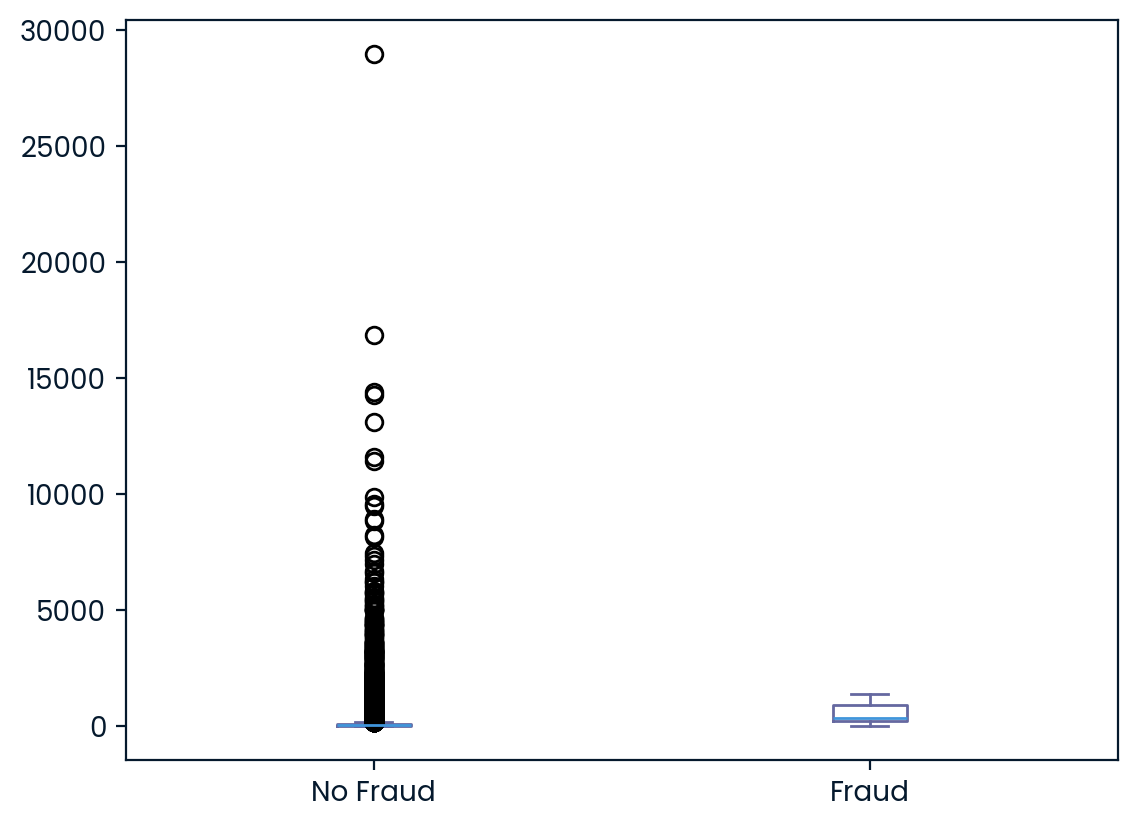

In [5]:
#CONSIDER AMOUNT TRANSACTION ON RESULT

amt_fraud = pd.DataFrame({"No Fraud":ccf_nofraud.amt,"Fraud":ccf_fraud.amt})
ax_amt = amt_fraud.plot(kind = "box")

#can I get the underlying statistics

amt_fraud_stats = pd.DataFrame({"Standard Deviation":
                   {"No Fraud":np.std(ccf_nofraud.amt),"Fraud":np.std(ccf_fraud.amt)},
                   "Mean":
                   {"No Fraud":np.mean(ccf_nofraud.amt),"Fraud":np.mean(ccf_fraud.amt)},
                   "Median":
                   {"No Fraud":np.median(ccf_nofraud.amt),"Fraud":np.median(ccf_fraud.amt)}
                  })
print(amt_fraud_stats.T)


Graph above suggests fraud transactions tend to have significantly less variance than non fraud amounts + on larger amounts on average

In [38]:
## VISUALISE
gdf = gpd.read_file(r'cb_2018_us_state_500k')

#for now I want to exclude Hawaii and Alaska and other weird territories
gdf_drop = gdf[~gdf.STUSPS.isin(["PR","VI","MP","GU","AS"])]

gdf_drop.rename(columns = {"STUSPS":"state"},inplace = True)

ccf_state = gdf_drop.merge(ccf[["state","is_fraud"]].groupby("state")["is_fraud"].sum(), on="state", how="left")


#create color column
ccf_state.fillna(0,inplace = True)
vmax = ccf_state.is_fraud.max()
colormap = "YlOrRd"

#color normalise
norm = mcols.Normalize(0,vmax,clip = True)
mapper = plt.cm.ScalarMappable(norm = norm, cmap = plt.cm.YlOrRd)
ccf_state["color"] = ccf_state["is_fraud"].apply(lambda x: mcols.to_hex(mapper.to_rgba(x)))

#plt
fig_state, (ax_state1,ax_state2) = plt.subplots(2,1)

#turn off axis
ax_state1.axis("off")

#ccf_state.plot(ax = ax_state,cmap = None, legend = True)
#ccf_state

visframe = ccf_state.to_crs({'init':'epsg:2163'})

for row in visframe.itertuples():
    if row.state not in ["AK","HI"]:
        vf = visframe[visframe.state == row.state]
        c = ccf_state[ccf_state.state == row.state][0:1].color.item()
        vf.plot(color = c, linewidth = 0.8, ax = ax_state1)

ccf_state_bar = ccf_state.groupby("state")["is_fraud"].sum()
ccf_state_bar = ccf_state_bar[~(ccf_state_bar == 0)]
ccf_state_bar = ccf_state[["color","state"]].merge(ccf_state_bar, on = "state").sort_values(by = "is_fraud",ascending = False)

ccf_state_bar.plot("state","is_fraud",ax = ax_state2, kind = "bar", color = ccf_state_bar.color, legend = False)

: 

In [ ]:
#ANALYSE - are older customers more likely victims of credit card fraud? What about older transactions?

age_fraud = pd.DataFrame({"No Fraud":ccf_nofraud.age,"Fraud":ccf_fraud.age})
ax_age = age_fraud.plot(kind = "box")

#can I get the underlying statistics

age_fraud_stats = pd.DataFrame({"Standard Deviation":
                   {"No Fraud":np.std(ccf_nofraud.age),"Fraud":np.std(ccf_fraud.amt)},
                   "Mean":
                   {"No Fraud":np.mean(ccf_nofraud.amt),"Fraud":np.mean(ccf_fraud.amt)},
                   "Median":
                   {"No Fraud":np.median(ccf_nofraud.amt),"Fraud":np.median(ccf_fraud.amt)}
                  })
print(amt_fraud_stats.T)


In [ ]:
#MODELLING

ccf.info()
#%%
#after EDA from interpreting above, going to drop the following columns which I do not believe will add to the model / date columns
dropcols = ["is_fraud","merchant","city","job","trans_num","trans_date_trans_time","dob"]

#create 2 separate datatables for the regression result and the y component
ccf_feature, ccf_y = ccf.drop(dropcols, axis = 1), ccf["is_fraud"] 

#dummy convert category columns to categorical variables
ccf_feature = pd.get_dummies(ccf_feature,columns = ["category","state"]) 

ccf_feature.head(5)

NameError: name 'ccf' is not defined